<a href="https://colab.research.google.com/github/LeeVvin/AIB_Project2/blob/main/Project2_AIB16_%EC%9D%B4%EB%B9%88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ENV

In [ ]:
'''
셀 실행 후 런타임 재시작 
'''
#!apt-get update -qq
#!apt-get install fonts-nanum* -qq
#import matplotlib.font_manager as fm
#from matplotlib import pyplot as plt
#path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'
#font_name = fm.FontProperties(fname=path, size=10).get_name()
#plt.rc('font', family=font_name)
#fm._rebuild()
#!pip install eli5 
#!pip install pdpbox
#!pip install shap

'\n셀 실행 후 런타임 재시작 \n'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline 

import plotly.offline as py
py.init_notebook_mode(connected = True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px 

import plotly.io as pio
pio.renderers.default = 'colab'
pio.renderers

import warnings
warnings.filterwarnings("ignore")

import os



from sklearn.cluster import KMeans

#FUNC

In [ ]:
def plot_missing_data(df):
    columns_with_null = df.columns[df.isna().sum() > 0]
    null_pct = (df[columns_with_null].isna().sum() / df.shape[0]).sort_values(ascending=False) * 100
    plt.figure(figsize=(8,6));
    sns.barplot(y = null_pct.index, x = null_pct, orient='h')
    plt.title('% Na values in dataframe by columns');


def histograms_and_countplots(column, data, columns_to_exclude):
    if column not in columns_to_exclude:
        if data[column].dtype not in ['int64', 'float64']:
            f, axes = plt.subplots(1,1,figsize=(15,5))
            sns.countplot(x=column, data = data)
            plt.xticks(rotation=90)
            plt.suptitle(column,fontsize=20)
            plt.show()
        else:
            g = sns.FacetGrid(data, margin_titles=True, aspect=4, height=3)
            g.map(plt.hist,column,bins=100)
            plt.show()
        plt.show()


def below_ten(units_sold):

  '''
  10개 미만 올림
  '''
  if units_sold < 10:
        return 10
  else:
        return units_sold



def is_successful(units_sold):

  '''
  인기상품 기준 1000개 라벨링하는 함수
  '''

  if units_sold > 1000:
        return 1
  else:
        return 0



def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

# DATA LOAD & PREPROCESSING

In [71]:
df = pd.read_csv('/content/drive/MyDrive/AI bootcamp/P2/summer-products-with-rating-and-performance_2020-08.csv')
display(df.head(3))

# 데이터 타입별 컬럼 수 확인하기
dtype_data = df.dtypes.reset_index()
dtype_data.columns = ["Count", "Column Type"]
dtype_data = dtype_data.groupby("Column Type").aggregate('count').reset_index()

print(dtype_data)

,title,title_orig,price,retail_price,currency_buyer,units_sold,uses_ad_boosts,rating,rating_count,rating_five_count,...,merchant_rating_count,merchant_rating,merchant_id,merchant_has_profile_picture,merchant_profile_picture,product_url,product_picture,product_id,theme,crawl_month
0,2020 Summer Vintage Flamingo Print Pajamas Se...,2020 Summer Vintage Flamingo Print Pajamas Se...,16.0,14,EUR,100,0,3.76,54,26.0,...,568,4.128521,595097d6a26f6e070cb878d1,0,NaN,https://www.wish.com/c/5e9ae51d43d6a96e303acdb0,https://contestimg.wish.com/api/webimage/5e9ae...,5e9ae51d43d6a96e303acdb0,summer,2020-08
1,SSHOUSE Summer Casual Sleeveless Soirée Party ...,Women's Casual Summer Sleeveless Sexy Mini Dress,8.0,22,EUR,20000,1,3.45,6135,2269.0,...,17752,3.899673,56458aa03a698c35c9050988,0,NaN,https://www.wish.com/c/58940d436a0d3d5da4e95a38,https://contestimg.wish.com/api/webimage/58940...,58940d436a0d3d5da4e95a38,summer,2020-08
2,2020 Nouvelle Arrivée Femmes Printemps et Été ...,2020 New Arrival Women Spring and Summer Beach...,8.0,43,EUR,100,0,3.57,14,5.0,...,295,3.989831,5d464a1ffdf7bc44ee933c65,0,NaN,https://www.wish.com/c/5ea10e2c617580260d55310a,https://contestimg.wish.com/api/webimage/5ea10...,5ea10e2c617580260d55310a,summer,2020-08


  Column Type  Count
0       int64     15
1     float64      9
2      object     19


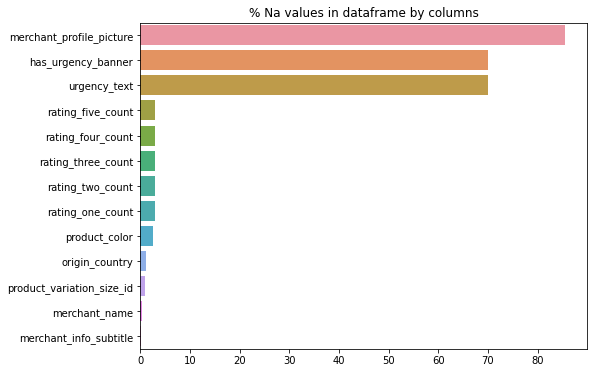

In [72]:
# 결측치 현황
plot_missing_data(df)
# 판매자 프로필 사진과 긴급 메세지(오늘까지 특가!) 등이 결측치가 많음

In [ ]:
# 중복된 항목 수 알아보기
print("중복된 항목 수 :", len(df[df.duplicated()])) 
# 중복된 항목 확인
print(df[df.duplicated(keep = False)].sort_values(by=list(df.columns)).head()) 
# 중복된 항목 제거
df.drop_duplicates(inplace=True, keep='first', ignore_index = True)

중복된 항목 수 : 34
                                                  title  \
557   2019 Mode féminine Hot Summer Fashion Flare Sl...   
1444  2019 Mode féminine Hot Summer Fashion Flare Sl...   
757   2019 été nouvelle mode féminine "Let It ~" Bee...   
1271  2019 été nouvelle mode féminine "Let It ~" Bee...   
789   2020 Shorts classiques pour hommes d'été Panta...   

                                             title_orig  price  retail_price  \
557   2019 Women's Fashion Hot Summer Fashion Flare ...   11.0            10   
1444  2019 Women's Fashion Hot Summer Fashion Flare ...   11.0            10   
757   2019 Summer New Women Fashion “ Let It ~“ Bee ...   11.0            10   
1271  2019 Summer New Women Fashion “ Let It ~“ Bee ...   11.0            10   
789   2020 Summer Men's Classic Shorts Multi-pocket ...    7.0            17   

     currency_buyer  units_sold  uses_ad_boosts  rating  rating_count  \
557             EUR         100               0    3.96            98   
1444

# EDA

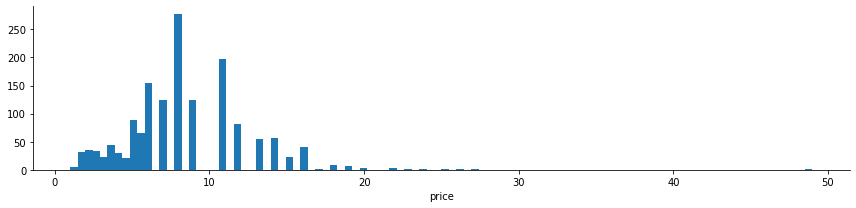

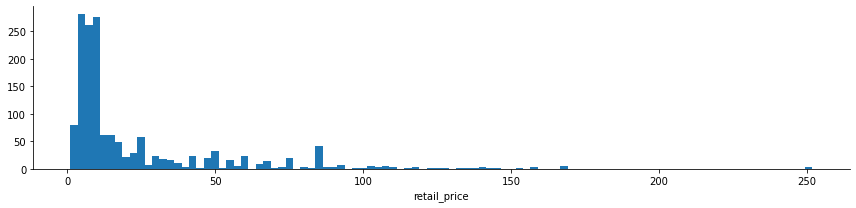

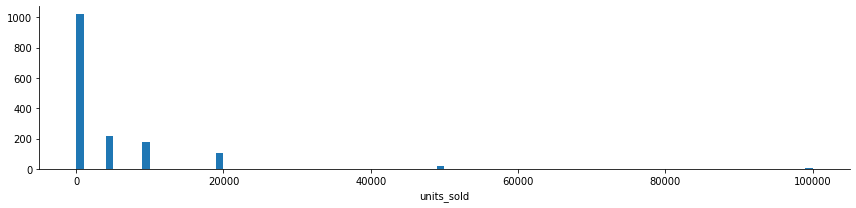

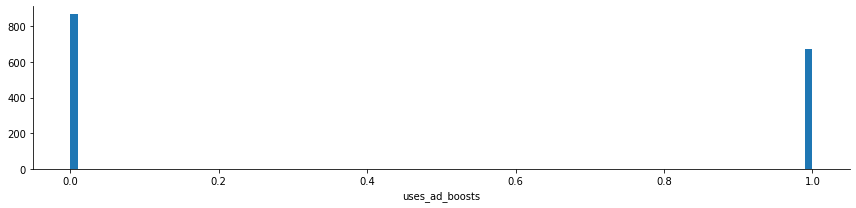

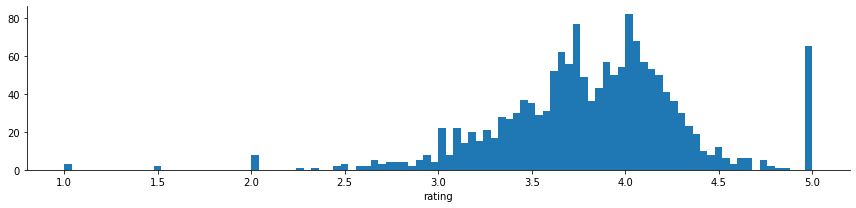

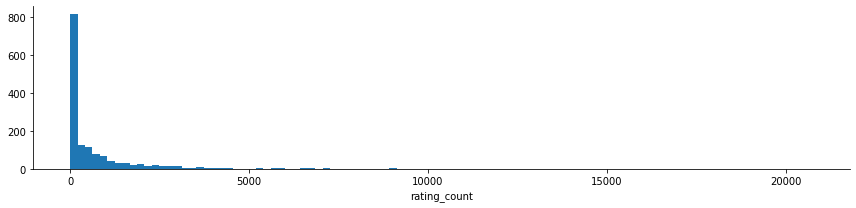

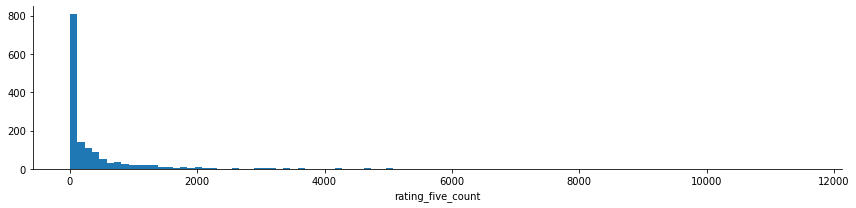

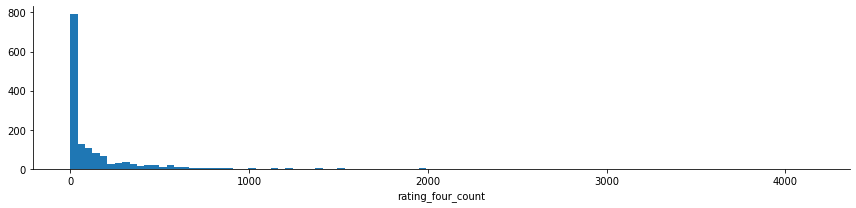

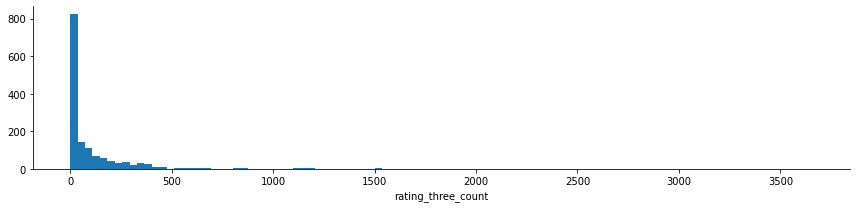

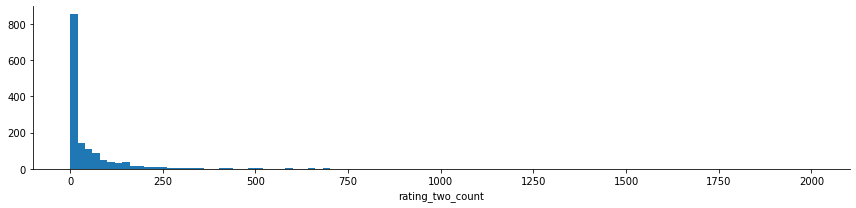

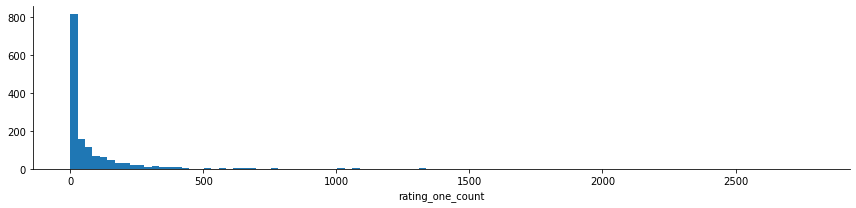

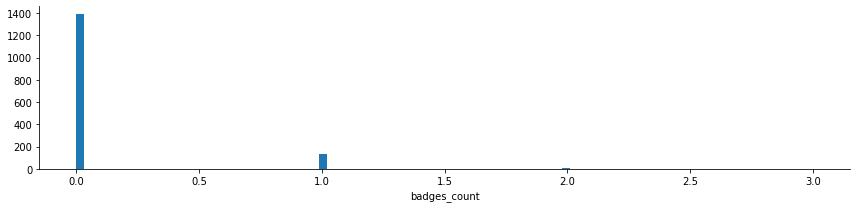

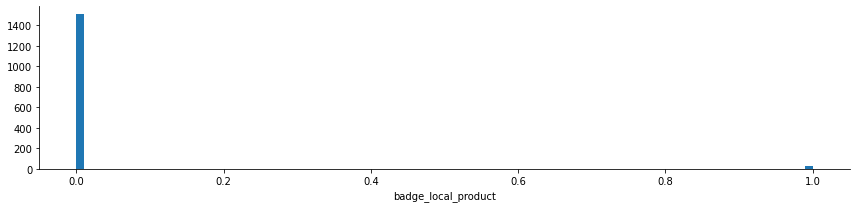

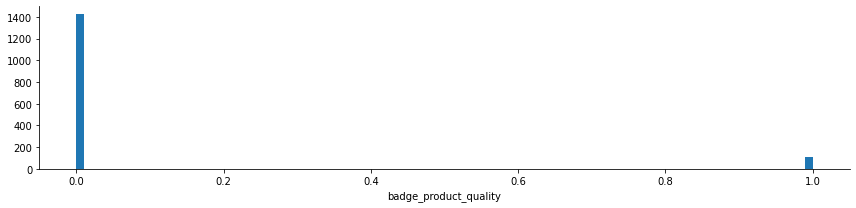

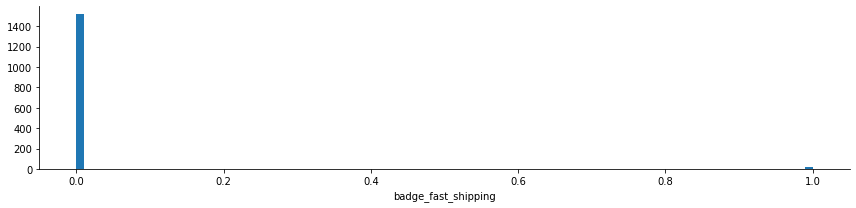

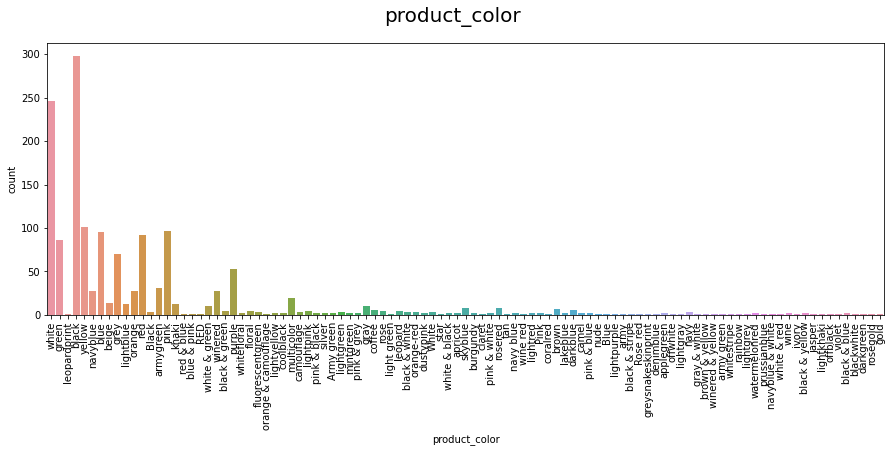

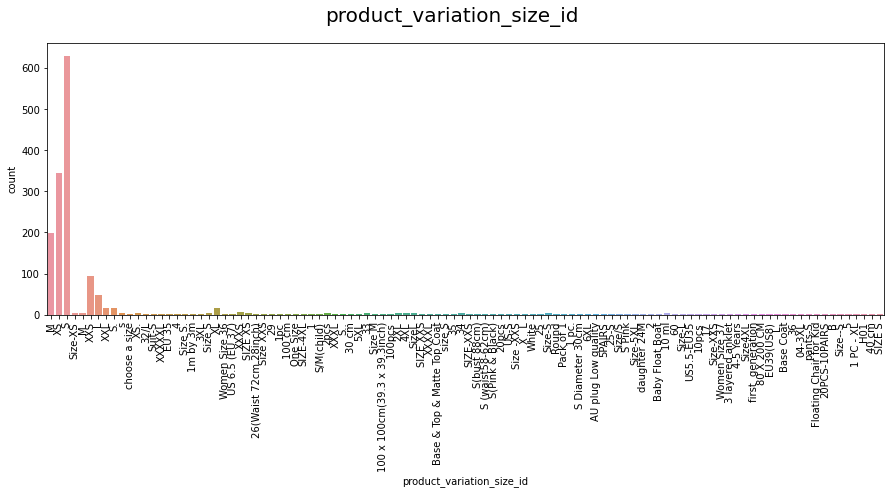

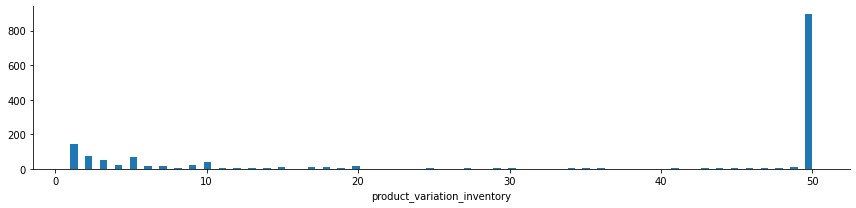

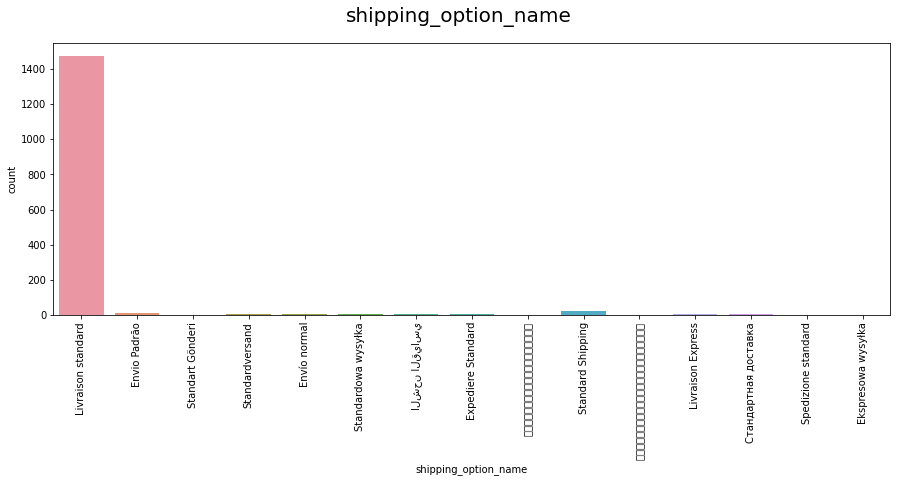

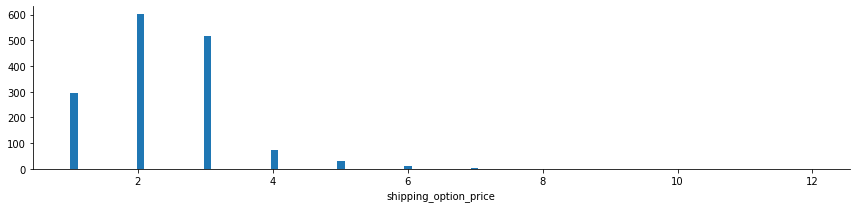

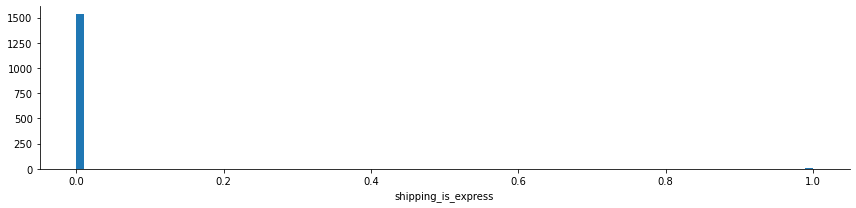

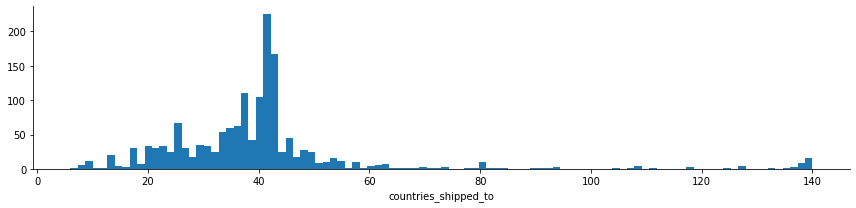

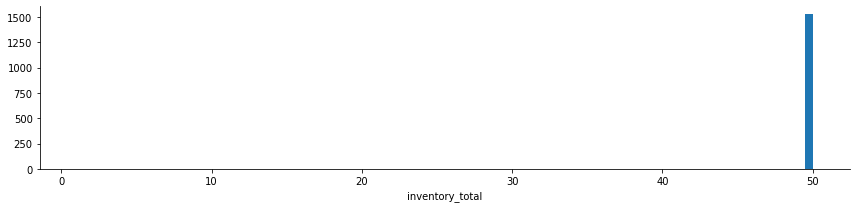

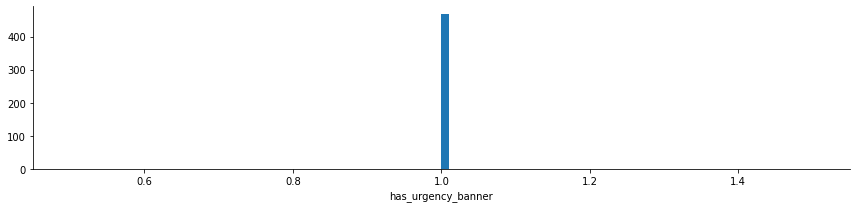

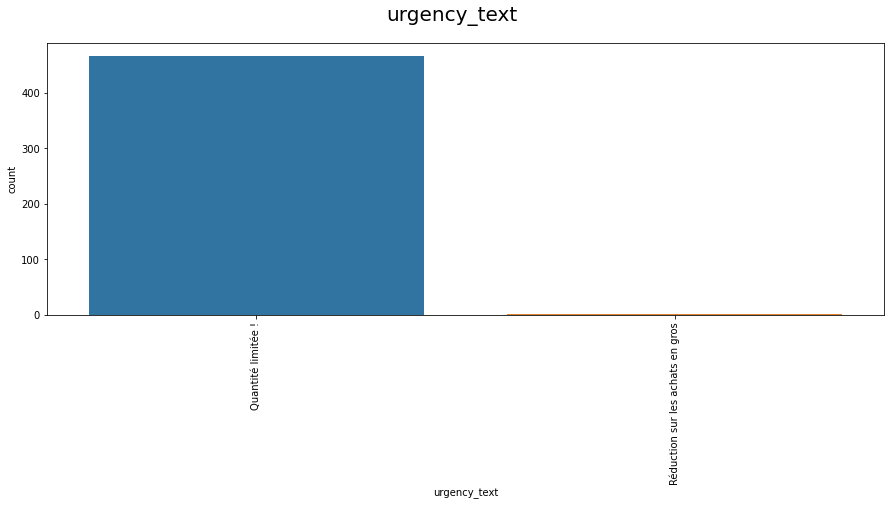

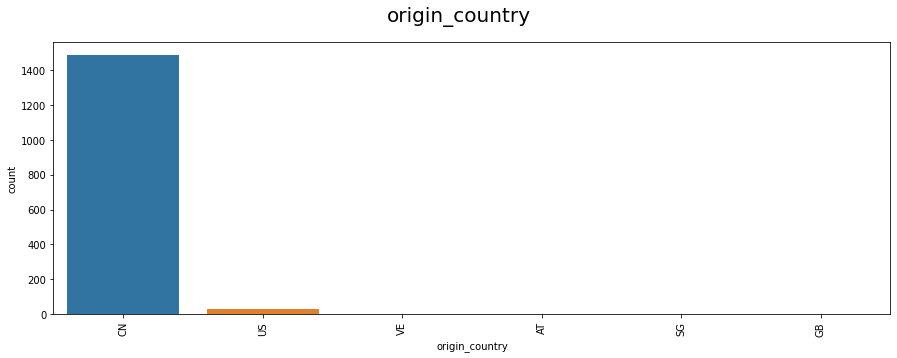

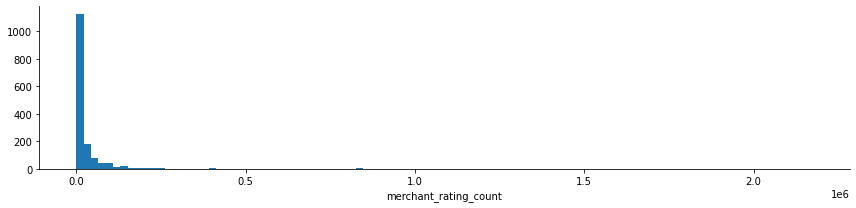

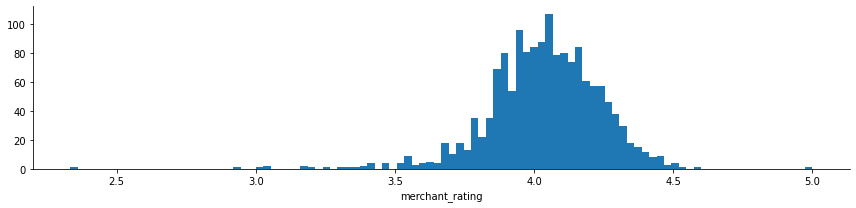

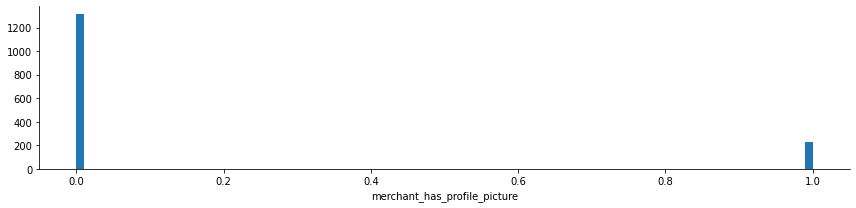

In [ ]:
col  = ['title', 'title_orig', 'currency_buyer', 'tags', 'merchant_title', 'merchant_name', 
                'merchant_info_subtitle', 'merchant_id', 'merchant_profile_picture', 'product_url', 
                'product_picture', 'product_id', 'theme', 'crawl_month' ]
                
for column in df.columns:
    histograms_and_countplots(column, df, col)

## 판매 현황 및 인기 상품

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,1539.0,8.356452,3.937161,1.000000,5.825000,8.00000,11.00000,49.0
retail_price,1539.0,23.317089,30.309642,1.000000,7.000000,10.00000,26.00000,252.0
units_sold,1539.0,4422.480182,9438.316389,1.000000,100.000000,1000.00000,5000.00000,100000.0
uses_ad_boosts,1539.0,0.435997,0.496048,0.000000,0.000000,0.00000,1.00000,1.0
rating,1539.0,3.822840,0.508619,1.000000,3.550000,3.85000,4.11000,5.0
rating_count,1539.0,907.372320,2001.720315,0.000000,26.000000,161.00000,873.00000,20744.0
rating_five_count,1496.0,450.738636,988.686287,0.000000,13.000000,84.00000,431.00000,11548.0
rating_four_count,1496.0,183.036096,403.989857,0.000000,5.000000,33.00000,171.00000,4152.0
rating_three_count,1496.0,137.152406,314.441561,0.000000,4.000000,26.00000,134.00000,3658.0
rating_two_count,1496.0,64.948529,152.701473,0.000000,2.000000,12.00000,64.00000,2003.0


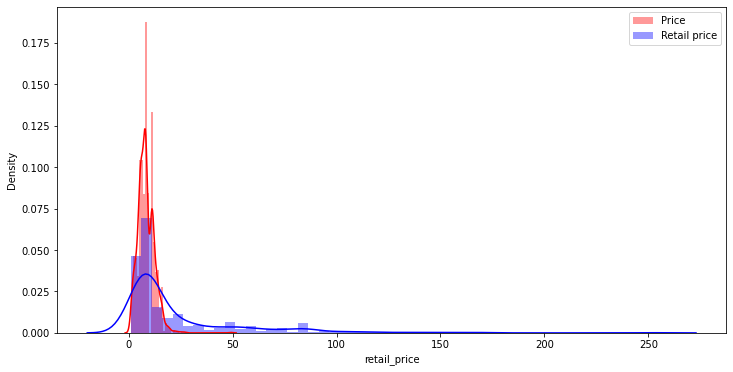

In [ ]:
# Retail price는 다양한 가격대, Price는 비슷한 가격대가 모여있음
plt.figure(figsize=(12,6))
sns.distplot(df['price'], color='red', label='Price')
sns.distplot(df['retail_price'], color='blue', label='Retail price')
plt.legend();

In [ ]:
fig = go.Figure()
fig.add_trace(go.Box(x=df['retail_price'], name='Retail Price'))
fig.add_trace((go.Box(x=df['price'], name='Price')))
fig['layout']['title'] = 'Distribution of Price and Retail Price'
fig.show()

## Units Sold 데이터

In [ ]:
print('단위 판매량 Median : ',df['units_sold'].median())
print('단위 판매량 Mean : ',df['units_sold'].mean())
df['units_sold'].value_counts()

단위 판매량 Median :  1000.0
단위 판매량 Mean :  4422.480181936322


100       493
1000      403
5000      216
10000     176
20000     103
50         68
10         44
50000      17
100000      6
1           3
8           3
7           2
2           2
3           2
6           1
Name: units_sold, dtype: int64

In [ ]:
# 10 미만 10으로 올리기
df['units_sold'] = df['units_sold'].apply(below_ten)
df['units_sold'].value_counts()

100       493
1000      403
5000      216
10000     176
20000     103
50         68
10         57
50000      17
100000      6
Name: units_sold, dtype: int64

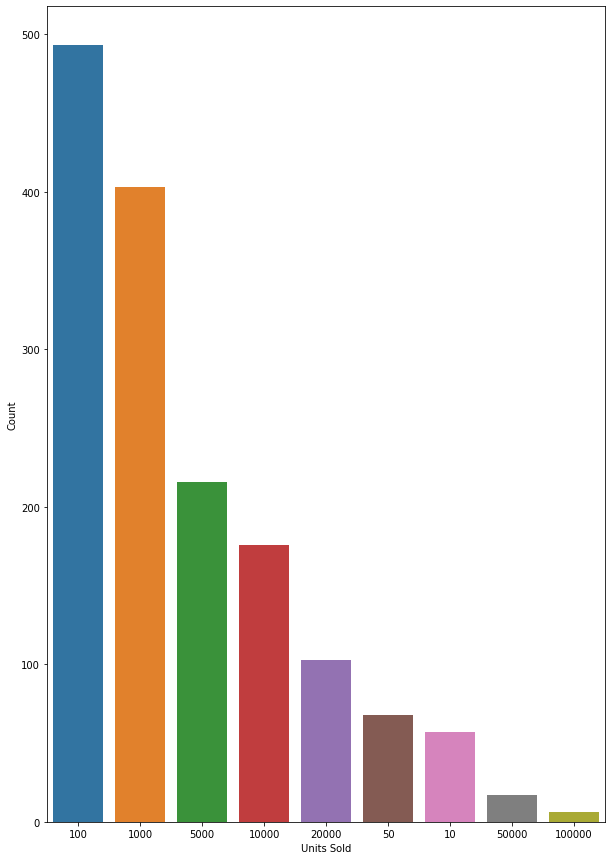

In [ ]:
fig_dims = (10, 15)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot('units_sold',
              data = df,
              order = df['units_sold'].value_counts().index,
              ax = ax)
ax.set(xlabel='Units Sold', ylabel='Count')
plt.show()

In [76]:
px.scatter(df, x='units_sold', y='price',marginal_x='box', title='Price vs Units Sold')

## 인기상품 기준 1000개 라벨링

Percent of successful products:  33.6582196231319


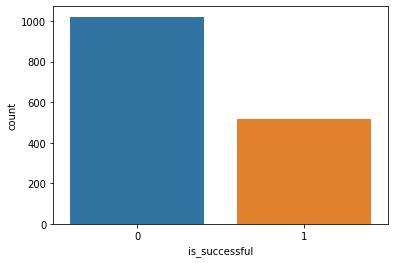

In [ ]:
# 1000개 이상 팔리면 is_succesful(인기상품)으로
df['is_successful'] = df['units_sold'].apply(is_successful)
print('Percent of successful products: ', df['is_successful'].value_counts()[1] / len(df['is_successful'])*100)
sns.countplot(data=df, x='is_successful')
plt.show()

# Units SOld 기준으로 클러스터링과 판매량 예측 모델링

In [ ]:
print(f" 판매량 데이터 확인 : {sorted(df['units_sold'].unique())}")

 판매량 데이터 확인 : [10, 50, 100, 1000, 5000, 10000, 20000, 50000, 100000]


Select K with Elbow Method

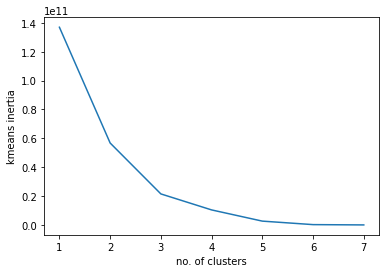

In [ ]:
from sklearn.cluster import KMeans

clusters = {}
for i in range(1,8):
    kmeans = KMeans(n_clusters=i).fit(df[['units_sold']])
    clusters[i] = kmeans.inertia_
    
plt.plot(list(clusters.keys()), list(clusters.values()));
plt.xlabel('no. of clusters');
plt.ylabel('kmeans inertia');   

In [ ]:
df['units_sold_cluster'] = KMeans(n_clusters=3).fit(df[['units_sold']]).predict(df[['units_sold']])
df = order_cluster('units_sold_cluster','units_sold',df,True)
df.groupby(['units_sold_cluster'])['units_sold'].describe()

,count,mean,std,min,25%,50%,75%,max
units_sold_cluster,,,,,,,,
0,1237.0,1241.932094,1776.364666,10.0,100.0,1000.0,1000.0,5000.0
1,279.0,13691.756272,4834.487556,10000.0,10000.0,10000.0,20000.0,20000.0
2,23.0,63043.478261,22448.887927,50000.0,50000.0,50000.0,75000.0,100000.0


## 상관성에 따른 클러스터 분석

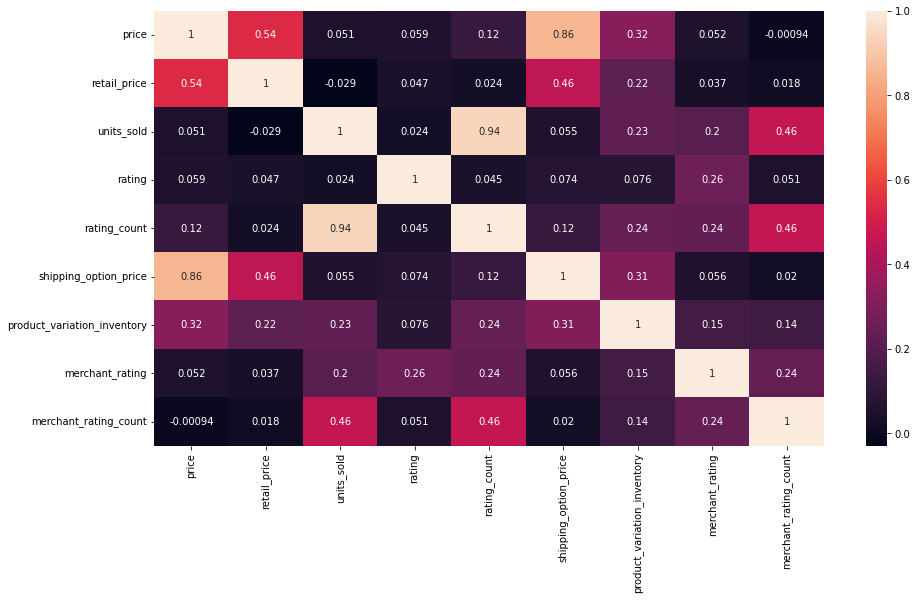

In [ ]:
features= ['price','retail_price','units_sold','rating','rating_count','shipping_option_price','product_variation_inventory','merchant_rating','merchant_rating_count']
corr = df[features].corr(method='spearman')
plt.figure(figsize=(15,8));
sns.heatmap(corr,annot=True);

In [ ]:
px.scatter(df,x='units_sold',y='rating', color='units_sold_cluster', marginal_y ='box',title='Rating vs units sold')

In [ ]:
px.scatter(df,x='rating',y='merchant_rating', color='units_sold_cluster', marginal_y ='box',title='Merchant Rating vs units sold', opacity=0.7)

In [ ]:
px.scatter(df,x='rating', y='product_variation_inventory', color='units_sold_cluster', title='Product variation vs Rating')

In [ ]:
fig = px.scatter(df,x='rating_count',y='rating', color='units_sold_cluster', title='Rating vs Rating count')
fig.update_layout(showlegend=False)

In [ ]:
px.scatter(df,x='retail_price', y='price',color='units_sold_cluster',marginal_y='box')

In [ ]:
px.scatter(df, x='price', y='shipping_option_price', color= 'units_sold_cluster', title='Shipping price vs Price')

# 할인율과 클러스터

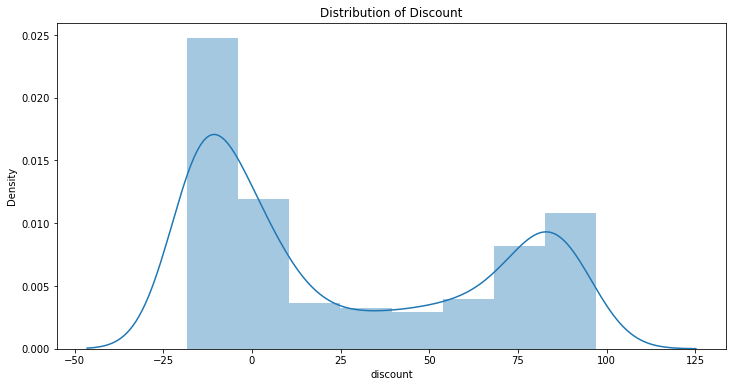

In [ ]:
# 할인율
df['difference'] = df['retail_price'] - df['price']
df['discount'] = df['difference']/df['retail_price'] *100
plt.figure(figsize=(12,6))
sns.distplot(df['discount']);
plt.title('Distribution of Discount');

In [ ]:
px.scatter(df,x='discount', y='rating_count', color='units_sold_cluster')

# Classifier를 통한 판매량 예측

In [ ]:
# 데이터 정제
salesData = df.drop(['is_successful','units_sold_cluster','crawl_month','product_id','product_picture', 'product_url', 'merchant_profile_picture', 'merchant_id', 'currency_buyer'], axis = 1)
salesData = salesData.drop(['theme','urgency_text', 'merchant_title', 'merchant_name', 'merchant_info_subtitle'], axis = 1)
salesData = salesData.drop(['title','title_orig','tags'], axis = 1)
salesData = salesData.drop(['shipping_option_name'], axis = 1)
salesData = salesData.drop(['rating_count'], axis = 1)
display(salesData.head(3))

,price,retail_price,units_sold,uses_ad_boosts,rating,rating_five_count,rating_four_count,rating_three_count,rating_two_count,rating_one_count,...,shipping_is_express,countries_shipped_to,inventory_total,has_urgency_banner,origin_country,merchant_rating_count,merchant_rating,merchant_has_profile_picture,difference,discount
0,16.0,14,100,0,3.76,26.0,8.0,10.0,1.0,9.0,...,0,34,50,1.0,CN,568,4.128521,0,-2.0,-14.285714
1,8.0,43,100,0,3.57,5.0,4.0,2.0,0.0,3.0,...,0,36,50,1.0,CN,295,3.989831,0,35.0,81.395349
2,8.0,8,5000,1,4.03,295.0,119.0,87.0,42.0,36.0,...,0,41,50,NaN,CN,23832,4.020435,0,0.0,0.000000


# Target Feature 정의

In [ ]:
print(f"유일한 값 : {salesData['units_sold'].unique()}")
print('\n')
print(salesData['units_sold'].value_counts())

# 데이터 타입별 컬럼 수 확인
dtype_data = salesData.dtypes.reset_index()
dtype_data.columns = ["Count", "Column Type"]
dtype_data = dtype_data.groupby("Column Type").aggregate('count').reset_index()

print(dtype_data)

유일한 값 : [   100   5000     10   1000     50  20000  10000  50000 100000]


100       493
1000      403
5000      216
10000     176
20000     103
50         68
10         57
50000      17
100000      6
Name: units_sold, dtype: int64
  Column Type  Count
0       int64     14
1     float64     11
2      object      3


In [ ]:
# 범주형 변수
salesData.select_dtypes(include=['object','category']).head()

,product_color,product_variation_size_id,origin_country
0,white,M,CN
1,leopardprint,XS,CN
2,black,M,CN
3,yellow,S,CN
4,navyblue,Size-XS,CN


In [ ]:
# 카테고리 features
cat_feat = salesData.select_dtypes('object','category').columns.values
salesData_cat = salesData[cat_feat].copy()
print(salesData_cat.nunique().sort_values())
print('\n')

salesData_cat_dummies = pd.get_dummies(salesData_cat)
display(salesData_cat_dummies.head(3))

origin_country                 6
product_color                101
product_variation_size_id    106
dtype: int64




,product_color_Army green,product_color_Black,product_color_Blue,product_color_Pink,product_color_RED,product_color_Rose red,product_color_White,product_color_applegreen,product_color_apricot,product_color_army,...,product_variation_size_id_first generation,product_variation_size_id_pants-S,product_variation_size_id_s,product_variation_size_id_size S,origin_country_AT,origin_country_CN,origin_country_GB,origin_country_SG,origin_country_US,origin_country_VE
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
# 숫자형 features
salesData.select_dtypes(include=['number']).head()
num_feat = salesData.select_dtypes('number').columns.values
salesData_num = salesData[num_feat].copy()
print(salesData_num.nunique().sort_values())

has_urgency_banner                1
badge_product_quality             2
uses_ad_boosts                    2
merchant_has_profile_picture      2
shipping_is_express               2
badge_local_product               2
badge_fast_shipping               2
badges_count                      4
shipping_option_price             8
units_sold                        9
inventory_total                  10
product_variation_inventory      48
countries_shipped_to             94
retail_price                    104
price                           127
rating                          192
rating_two_count                262
difference                      282
rating_one_count                330
rating_three_count              384
rating_four_count               440
discount                        452
rating_five_count               605
merchant_rating_count           917
merchant_rating                 952
dtype: int64


In [ ]:
# 유일한 값이 1개인 경우 or 모든 행의 값이 다른 경우 제거 + Target Feature가 포함되어 있으면 함께 제거
salesData_num = salesData_num.drop(['has_urgency_banner','units_sold'], axis=1, errors='ignore')
display(salesData_num.isnull().any())

price                           False
retail_price                    False
uses_ad_boosts                  False
rating                          False
rating_five_count                True
rating_four_count                True
rating_three_count               True
rating_two_count                 True
rating_one_count                 True
badges_count                    False
badge_local_product             False
badge_product_quality           False
badge_fast_shipping             False
product_variation_inventory     False
shipping_option_price           False
shipping_is_express             False
countries_shipped_to            False
inventory_total                 False
merchant_rating_count           False
merchant_rating                 False
merchant_has_profile_picture    False
difference                      False
discount                        False
dtype: bool

In [ ]:
salesData_num.fillna(0, inplace = True)

# 상관성에 따른 Feature 정제

In [ ]:
from scipy.stats import pearsonr, chi2_contingency
from itertools import combinations

num_feat = salesData_num.columns.values
comb_num_feat = np.array(list(combinations(num_feat, 2)))
corr_num_feat = np.array([])
# 피어슨 상관계수
for comb in comb_num_feat:
    corr = pearsonr(salesData_num[comb[0]], salesData_num[comb[1]])[0]
    corr_num_feat = np.append(corr_num_feat, corr)

In [ ]:

high_corr_num = comb_num_feat[np.abs(corr_num_feat) >= 0.9]
high_corr_num

array([['retail_price', 'difference'],
       ['rating_five_count', 'rating_four_count'],
       ['rating_five_count', 'rating_three_count'],
       ['rating_four_count', 'rating_three_count'],
       ['rating_four_count', 'rating_two_count'],
       ['rating_three_count', 'rating_two_count'],
       ['rating_three_count', 'rating_one_count'],
       ['rating_two_count', 'rating_one_count']], dtype='<U28')

In [ ]:
salesData_num = salesData_num.drop(['difference','rating_five_count','rating_four_count','rating_three_count','rating_two_count','rating_one_count'], axis=1, errors='ignore')

# Modeling

In [ ]:
# 최종 데이터 확인
train_final = pd.concat([salesData['units_sold'], salesData_num, salesData_cat_dummies], axis=1)
display(train_final.head(3))


,units_sold,price,retail_price,uses_ad_boosts,rating,badges_count,badge_local_product,badge_product_quality,badge_fast_shipping,product_variation_inventory,...,product_variation_size_id_first generation,product_variation_size_id_pants-S,product_variation_size_id_s,product_variation_size_id_size S,origin_country_AT,origin_country_CN,origin_country_GB,origin_country_SG,origin_country_US,origin_country_VE
0,100,16.0,14,0,3.76,0,0,0,0,50,...,0,0,0,0,0,1,0,0,0,0
1,100,8.0,43,0,3.57,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,5000,8.0,8,1,4.03,0,0,0,0,50,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
from sklearn.model_selection import train_test_split

r_state = 3
X = train_final.drop(['units_sold'], axis = 1)
y = train_final['units_sold']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3, 
                                                    random_state = r_state)

# Baseline Model

In [ ]:
value = train_final['units_sold'].mode()[0]
y_pred = [value] * len(y_train)
print(f" base line모델의 score: {accuracy_score(y_train,y_pred)}")

 base line모델의 score: 0.32404828226555243


# Decision Tree Classifier

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score

classifier_DTC = DecisionTreeClassifier(random_state = r_state)
classifier_DTC.fit(X_train, y_train)

y_pred_DTC = classifier_DTC.predict(X_test)
accuracy_score(y_test, y_pred_DTC)

0.4134199134199134

# SVC

In [ ]:
from sklearn.svm import SVC

classifier_SVC = SVC(random_state = r_state)
classifier_SVC.fit(X_train, y_train)

y_pred_SVC = classifier_SVC.predict(X_test)
accuracy_score(y_test, y_pred_SVC)

0.3246753246753247

# AdaBoostClassifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

classifier_ABC = AdaBoostClassifier(learning_rate = 0.01,
                                   random_state = r_state) # Default using Decision Tree Classifier
classifier_ABC.fit(X_train, y_train)

y_pred_ABC = classifier_ABC.predict(X_test)
accuracy_score(y_test, y_pred_ABC)

0.36147186147186144

# RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

classifier_RFC = RandomForestClassifier(random_state = r_state)
classifier_RFC.fit(X_train, y_train)

y_pred_RFC = classifier_RFC.predict(X_test)
accuracy_score(y_test, y_pred_RFC)

0.4523809523809524

# AdaBoost - Random Forest

In [ ]:
classifier_ABC_RF = AdaBoostClassifier(RandomForestClassifier(random_state = r_state),
                                       learning_rate = 0.01,
                                       random_state = r_state) 
classifier_ABC_RF.fit(X_train, y_train)

y_pred_ABC_RF = classifier_ABC_RF.predict(X_test)
accuracy_score(y_test, y_pred_ABC_RF)

0.49567099567099565

# GradientBoostingClassifer

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

classifier_GBC = GradientBoostingClassifier(random_state = r_state)
classifier_GBC.fit(X_train, y_train)

y_pred_GBC = classifier_GBC.predict(X_test)
accuracy_score(y_test, y_pred_GBC)

0.41774891774891776

# KNeighborsClssifer

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

classifier_KNN = KNeighborsClassifier(n_neighbors = 5)
classifier_KNN.fit(X_train, y_train)

y_pred_KNN = classifier_KNN.predict(X_test)
accuracy_score(y_test, y_pred_KNN)

0.3246753246753247

# XGBClassifier

In [ ]:
from xgboost import XGBClassifier

classifier_XGB = XGBClassifier()
classifier_XGB.fit(X_train, y_train)

y_pred_XGB = classifier_XGB.predict(X_test)
accuracy_score(y_test, y_pred_XGB)

0.4069264069264069

In [ ]:
from sklearn.model_selection import cross_val_score

classifiers = [classifier_DTC, 
               classifier_SVC,
               classifier_ABC, 
               classifier_RFC, 
               classifier_ABC_RF, 
               classifier_GBC, 
               classifier_KNN, 
               classifier_XGB]
classifiers_names = ['Decision Tree',
                     'SVC', 
                     'AdaBoost',
                     'Random Forest',
                     'AdaBoost - Random Forest',
                     'Gradient Boosting',
                     'KNeighborsClassifier',
                     'XG Boost']
accuracy_mean = []

for cl in classifiers :
    accuracies = cross_val_score(estimator = cl, 
                                 X = X_train, 
                                 y = y_train, 
                                 cv = 4)
    accuracy_mean.append(accuracies.mean()*100)

    
accuracy_df = pd.DataFrame({'Classifier': classifiers_names,
                           'Accuracy Mean': accuracy_mean})
accuracy_df.sort_values('Accuracy Mean',ascending=False)

,Classifier,Accuracy Mean
4,AdaBoost - Random Forest,43.733306
3,Random Forest,43.082404
5,Gradient Boosting,39.740465
0,Decision Tree,39.370783
7,XG Boost,38.440383
2,AdaBoost,34.911882
1,SVC,33.522305
6,KNeighborsClassifier,31.567878


In [86]:
accuracy_df.loc[8] = ['Baseline',accuracy_score(y_train,y_pred)*100]
accuracy_df_sort = accuracy_df.sort_values(by='Accuracy Mean', ascending = False)
accuracy_df_sort

,Classifier,Accuracy Mean
4,AdaBoost - Random Forest,43.733306
3,Random Forest,43.082404
5,Gradient Boosting,39.740465
0,Decision Tree,39.370783
7,XG Boost,38.440383
2,AdaBoost,34.911882
1,SVC,33.522305
8,Baseline,32.404828
6,KNeighborsClassifier,31.567878


# VotingClassifier

In [ ]:
from sklearn.ensemble import VotingClassifier

voting_cl = VotingClassifier(estimators = [('Gradient Boosting', classifier_GBC),
                                              ('Decision Tree',classifier_RFC),
                                              ('XG Boost',classifier_DTC)], 
                                voting = 'hard')
voting_cl.fit(X_train, y_train)
y_pred_vcl = voting_cl.predict(X_test)
accuracy_score(y_test, y_pred_vcl)

0.4458874458874459

# GridSearchCV 

In [ ]:
from sklearn.model_selection import GridSearchCV

gb_params = [{'loss': ['deviance', 'exponential'], 
              'learning_rate': [0.1, 0.01, 0.001],
              'n_estimators': [100, 250, 500]}]

grid_search_GBC = GridSearchCV(estimator = classifier_GBC,
                               param_grid = gb_params,
                               scoring = 'accuracy',
                               cv = 4,
                               n_jobs = -1)

grid_search_GBC.fit(X_train, y_train)
best_accuracy_GBC = grid_search_GBC.best_score_
best_parameters_GBC = grid_search_GBC.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy_GBC*100))
print("Best Parameters:", best_parameters_GBC)

Best Accuracy: 42.71 %
Best Parameters: {'learning_rate': 0.1, 'loss': 'deviance', 'n_estimators': 500}


In [ ]:
optimised_GBC = GradientBoostingClassifier(random_state = r_state,
                                       loss = 'deviance',
                                       learning_rate = 0.1,
                                       n_estimators = 500)
optimised_GBC.fit(X_train, y_train)
y_pred_GBC = optimised_GBC.predict(X_test)
accuracy_score(y_test, y_pred_GBC)

0.47835497835497837

In [87]:
accuracy_df.loc[9] = ['OPTIMISED_GBC',accuracy_score(y_test, y_pred_GBC)*100]
accuracy_df_sort = accuracy_df.sort_values(by='Accuracy Mean', ascending = False)
accuracy_df_sort

,Classifier,Accuracy Mean
9,OPTIMISED_GBC,47.835498
4,AdaBoost - Random Forest,43.733306
3,Random Forest,43.082404
5,Gradient Boosting,39.740465
0,Decision Tree,39.370783
7,XG Boost,38.440383
2,AdaBoost,34.911882
1,SVC,33.522305
8,Baseline,32.404828
6,KNeighborsClassifier,31.567878


In [ ]:
%%capture

# Ignore this warning: https://github.com/dmlc/xgboost/issues/4300
# xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')


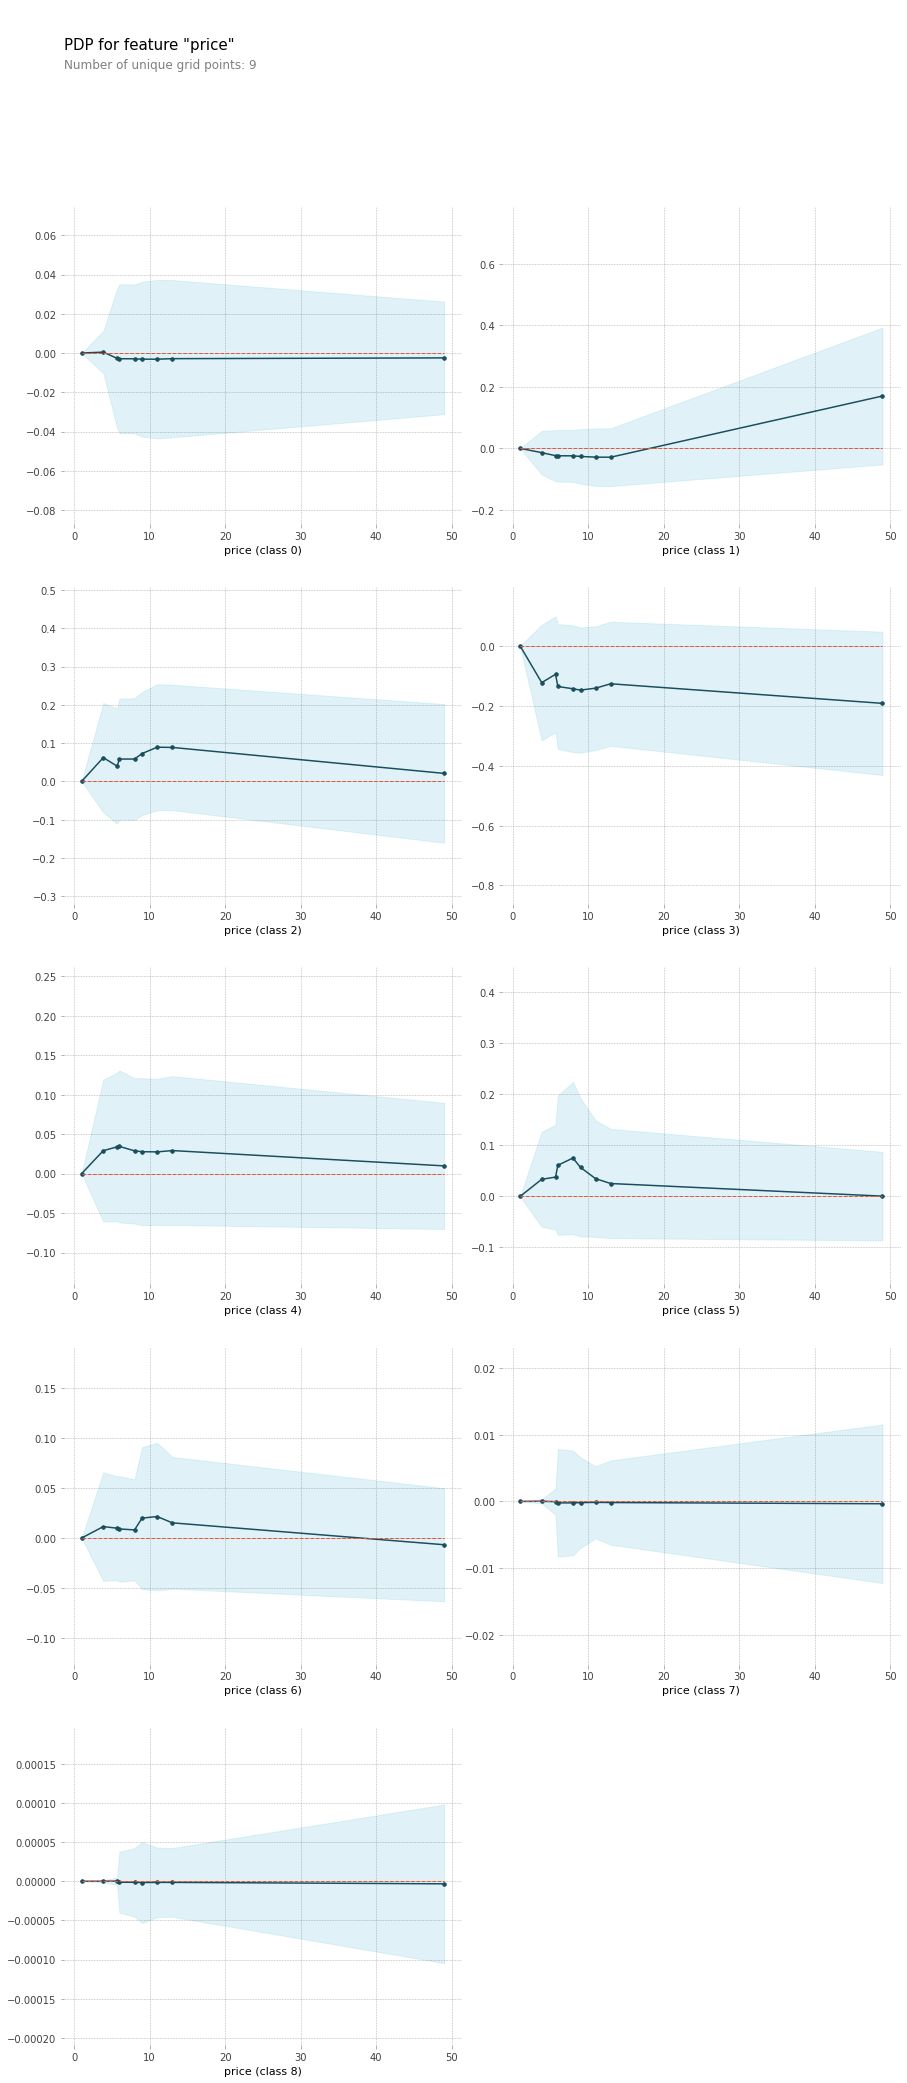

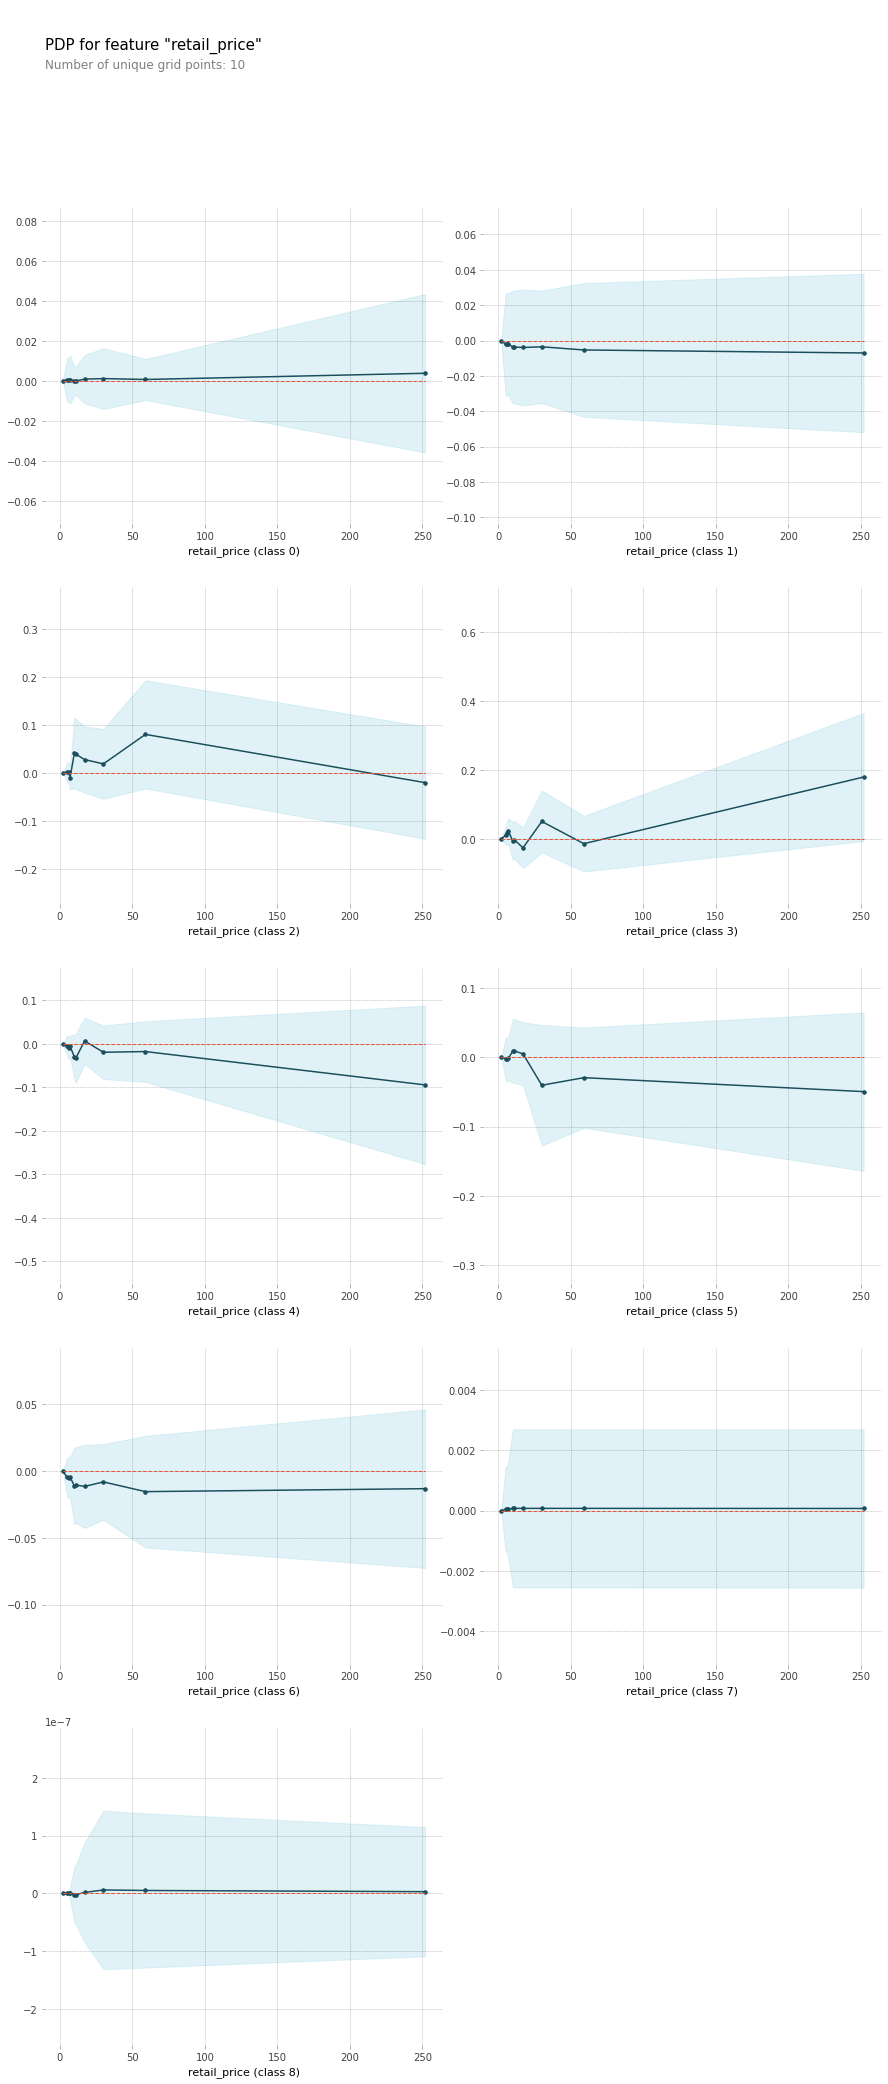

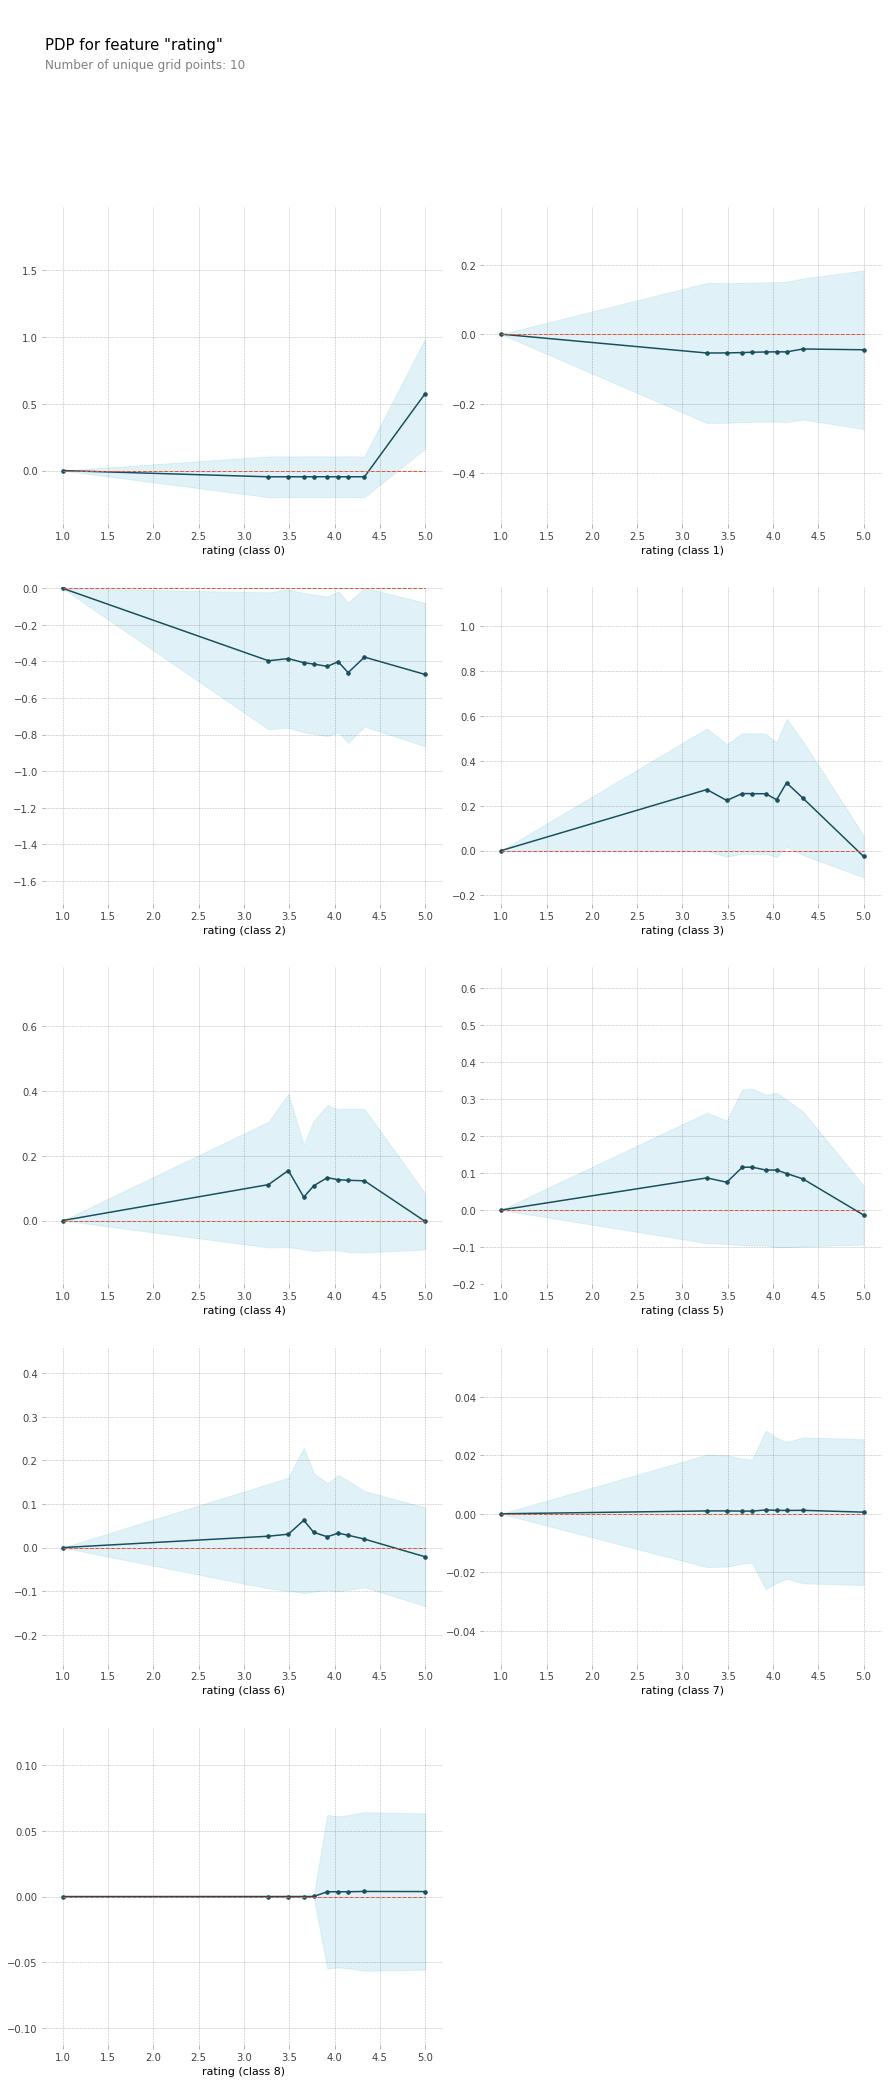

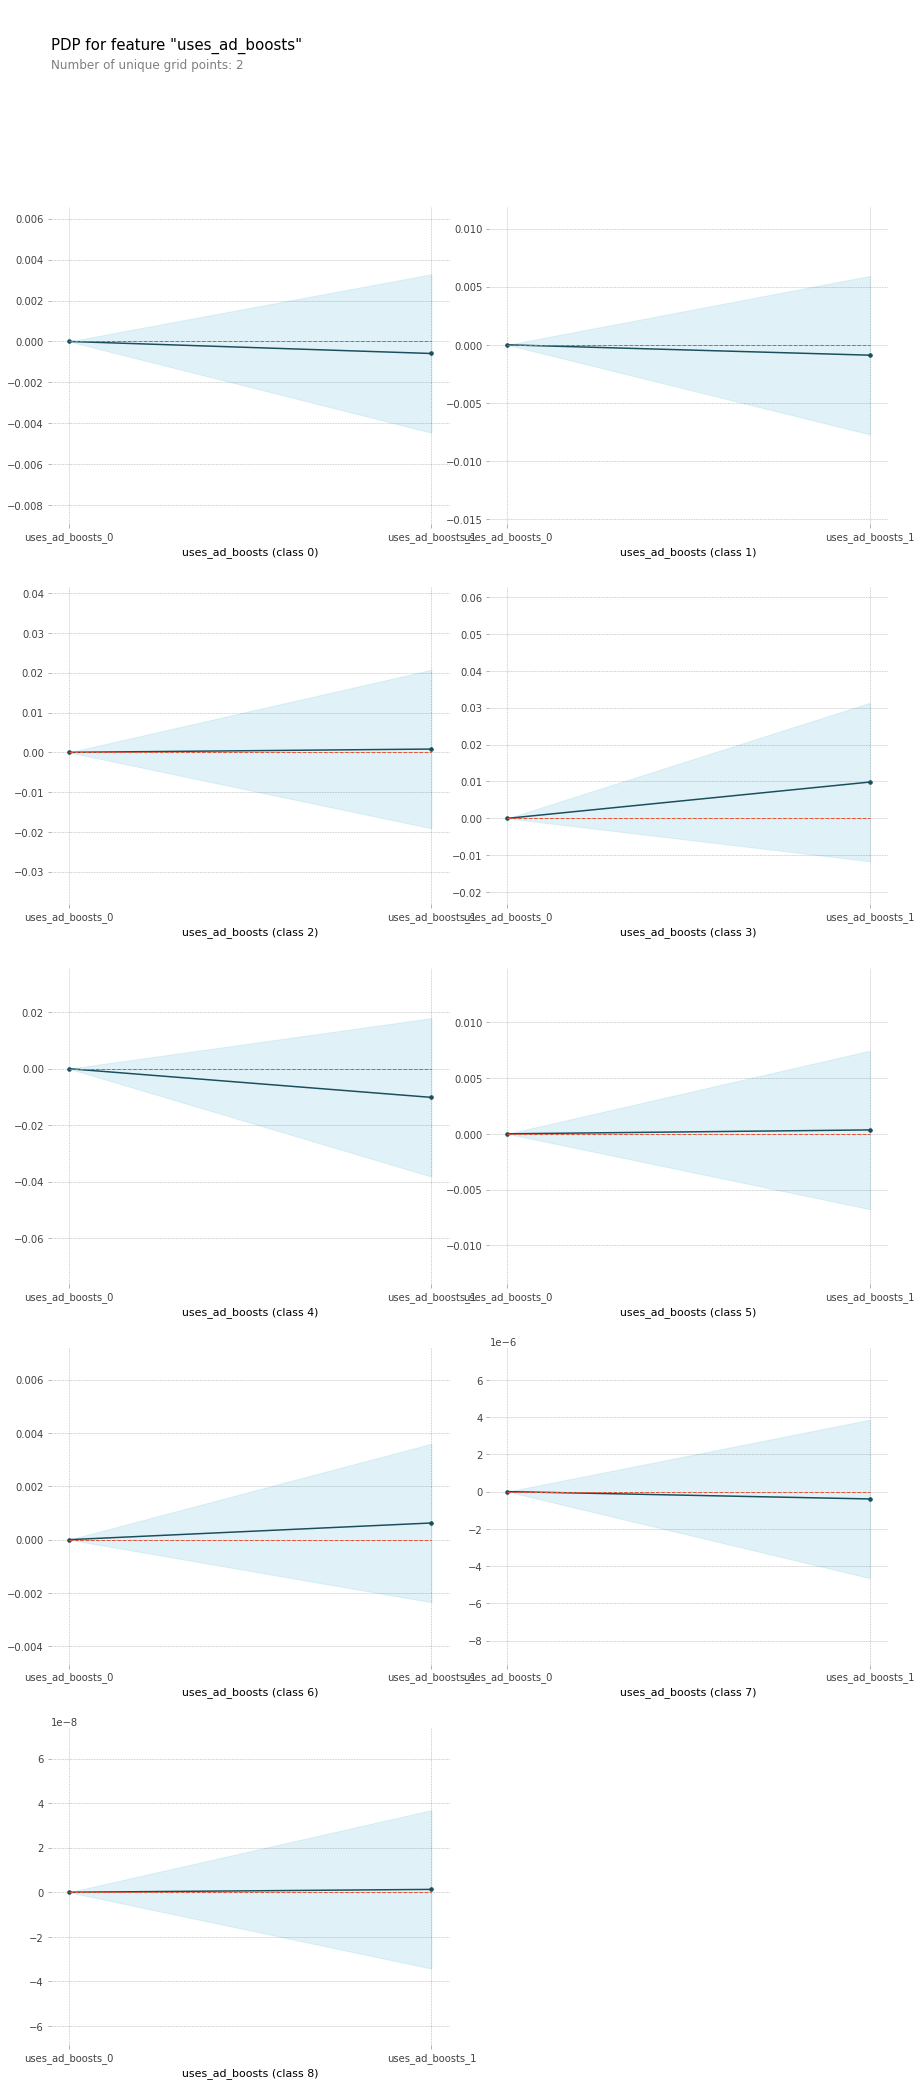

In [ ]:
# model = optimised_GBC
from pdpbox.pdp import pdp_isolate, pdp_plot
feat = ['price','retail_price','rating','uses_ad_boosts']
for feat in feat:
  isolated = pdp_isolate(model = optimised_GBC,
                         dataset = X_train,
                         model_features = X_train.columns,
                         feature = feat,
                         grid_type = 'percentile',
                         num_grid_points=10)
  pdp_plot(isolated, feature_name = feat)

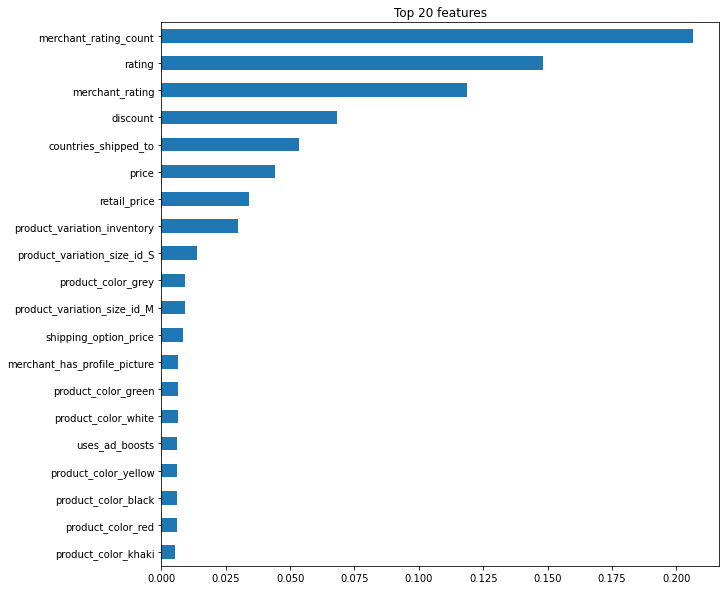

In [90]:
importances = pd.Series(optimised_GBC.feature_importances_, X_train.columns)
n = 20
plt.figure(figsize = (10 , n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh()
